In [17]:
import numpy as np
from bec.quantum_dot.dot import QuantumDot
from smef.core.drives.types import DriveSpec
from smef.engine import SimulationEngine, UnitSystem
from smef.core.units import Q

from bec.metrics.metrics import QDDiagnostics
from bec.quantum_dot.dot import QuantumDot
from bec.quantum_dot.enums import QDState, TransitionPair
from bec.quantum_dot.factories.drives import make_gaussian_field_drive_pi
from bec.quantum_dot.smef.initial_state import rho0_qd_vacuum
from bec.quantum_dot.spec.energy_structure import EnergyStructure
from bec.quantum_dot.spec.dipole_params import DipoleParams
from bec.quantum_dot.spec.cavity_params import CavityParams

from bec.light.classical.field_drive import ClassicalFieldDriveU
from bec.light.classical.amplitude import FieldAmplitude
from bec.light.classical.carrier import Carrier
from bec.light.envelopes.gaussian import GaussianEnvelopeU
from bec.light.core.polarization import JonesState
from bec.light.classical.carrier_profiles import constant as constant_detune

from bec.reporting.plotting.api import plot_run, plot_runs
from bec.reporting.plotting.grid import PlotConfig
from bec.metrics.metrics import QDDiagnostics


In [2]:
_SOLVE_OPTIONS = {
        "qutip_options": {
            "method": "bdf",
            "atol": 1e-10,
            "rtol": 1e-8,
            "nsteps": 200000,
            "max_step": 0.01,   # ns
            "progress_bar": "tqdm",
        }
    }

In [3]:
   

def make_qd() -> QuantumDot:
    # Old globals:
    # EXCITON = 1.300 eV
    # BINDING = 3e-3 eV
    # FSS = 5e-6 eV
    exciton = Q(1.300, "eV")
    binding = Q(3.0e-3, "eV")
    fss = Q(5.0e-6, "eV")

    energy = EnergyStructure.from_params(
        exciton=exciton,
        binding=binding,
        fss=fss,
    )

    # Old: DipoleParams(dipole_moment_Cm = 10 Debye)
    # 1 Debye = 3.33564e-30 C*m
    dipoles = DipoleParams.biexciton_cascade_from_fss(
        mu_default_Cm=Q(10.0 * 3.33564e-30, "C*m"),
        fss=fss,
    )

    # Old: CavityParams(Q=5e4, Veff_um3=0.5, lambda_nm=930.0, n=3.4)
    cavity = CavityParams.from_values(
        Q=5.0e4,
        Veff_um3=0.5,
        lambda_nm=930.0,
        n=3.4,
    )

    return QuantumDot(
        energy=energy,
        dipoles=dipoles,
        cavity=cavity,
        phonons=None,
    )


### Two-photon excitation (TPE) of the biexciton in ns units

This cell runs a minimal two-photon excitation (TPE) simulation of a four-level quantum dot (G, X1, X2, XX) using the SMEF engine with QuTiP as the backend.

Key choices:
- **Time axis in nanoseconds:** we set `time_unit_s = 1 ns`, so the solver `tlist` is directly interpreted as time in ns.
- **Resonant TPE condition:** for a two-photon drive, the laser carrier is set to  
  \(\omega_L = \frac{1}{2}\,\omega_{G\leftrightarrow XX}\),  
  so that \(2\omega_L\) matches the biexciton transition energy.
- **Gaussian \(\pi\)-pulse:** we use a Gaussian envelope centered at `t0_ns` with width `sigma_ns` (e.g. 0.05 ns = 50 ps) and set the amplitude such that the effective pulse area is \(\pi\).

Outputs:
- `res`: solver result (time grid, expectation values, and optionally states)
- `drive`: the constructed TPE drive object (used for plotting the envelope/carrier)
- `tlist`: the solver time grid in ns
- `units`: the unit system used for conversion/reporting

Finally, `plot_run(...)` produces a compact diagnostic plot showing the drive panel and the resulting QD populations (and any configured outputs).


chosen_final: [('G<->XX', '2ph', 1.0, 0.0, 0.0)]


  0%|          | 0/2000 [00:00<?, ?it/s]

QUANTUM DOT METRICS REPORT

STATE SANITY
------------------------------------------------------------------------------
Trace               : 1
Hermiticity error   : 7.85161e-17
Min eigenvalue      : -7.45112e-17

QD POPULATIONS (final state)
------------------------------------------------------------------------------
  G : 0.994564
 X1 : 0.00265572
 X2 : 0.00265572
 XX : 0.000124219

PHOTON NUMBER DECOMPOSITION (GX + XX)
------------------------------------------------------------------------------
p0        : 0.0638319
p1_total  : 0.00443971
p2_exact  : 0.911155

PHOTON NUMBER DECOMPOSITION (GX only)
------------------------------------------------------------------------------
p0        : 0.0682716
p1_total  : 0.912027
p2_exact  : 0.0197013

PHOTON NUMBER DECOMPOSITION (XX only)
------------------------------------------------------------------------------
p0        : 0.0638319
p1_total  : 0.915595
p2_exact  : 0.020573

PHOTON NUMBER EXPECTATION VALUES
----------------------------

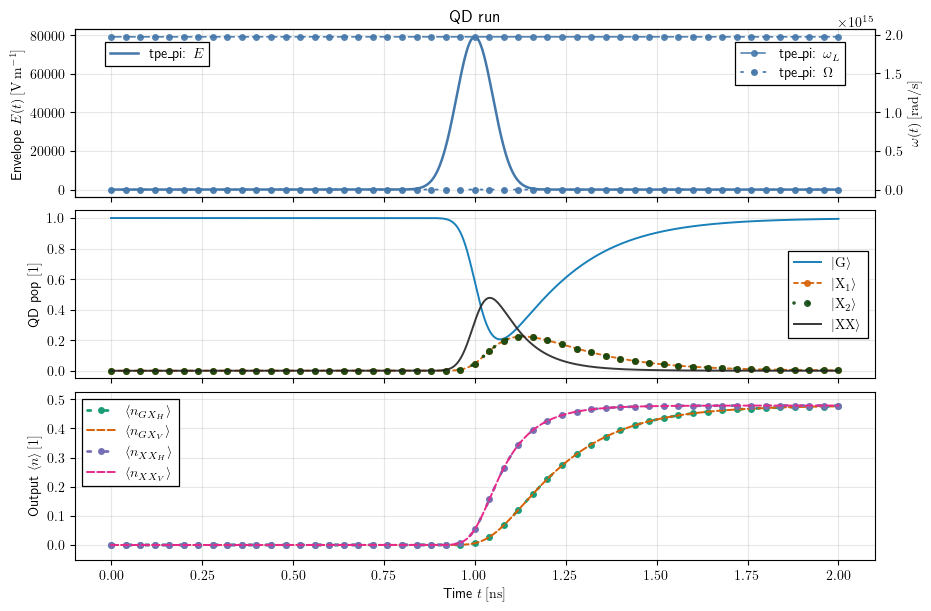

In [4]:
def run_tpe_excitation_ns(
    qd: QuantumDot,
    *,
    t_end_ns: float = 2.0,
    n_points: int = 2001,
    t0_ns: float = 1.0,
    sigma_ns: float = 0.05,   # 50 ps
):
    # 1 solver unit = 1 ns
    time_unit_s = float(Q(1.0, "ns").to("s").magnitude)
    units = UnitSystem(time_unit_s=time_unit_s)
    engine = SimulationEngine(audit=False)

    # Time axis in ns (because time_unit_s=1 ns)
    tlist = np.linspace(0.0, float(t_end_ns), int(n_points))

    bundle = qd.compile_bundle(units=units)
    dims = bundle.modes.dims()
    rho0 = rho0_qd_vacuum(dims=dims, qd_state=QDState.G)

    # Two-photon resonance: omega_L = 0.5 * omega_ref(G<->XX)
    omega_G_XX = float(qd.derived.omega_ref_rad_s(TransitionPair.G_XX))
    omega_L = 0.5 * omega_G_XX

    drive = make_gaussian_field_drive_pi(
        qd,
        pair=TransitionPair.G_XX,
        t0=Q(float(t0_ns), "ns"),
        sigma=Q(float(sigma_ns), "ns"),
        preferred_kind="2ph",
        label="tpe_pi",
        include_polaron=True,
        omega0_rad_s=omega_L,
        chirp_rate_rad_s2=None,
    )

    specs = [DriveSpec(payload=drive, drive_id=drive.label or "tpe")]



    res = engine.run(
        qd,
        tlist=tlist,
        time_unit_s=time_unit_s,
        rho0=rho0,
        drives=specs,
        solve_options=_SOLVE_OPTIONS,
    )

    return res, drive, tlist, units
qd=make_qd()
res, drive, tlist, units = run_tpe_excitation_ns(qd)
plot_run(res, units=units, drives=[drive], qd=qd);
metrics = QDDiagnostics().compute(qd, res, units=units)
print(metrics.to_text())


### Detuned two-photon excitation (constant detuning)

This cell repeats the two-photon excitation (TPE) simulation with a constant
two-photon detuning \(\Delta_{2\gamma}\neq 0\). The pulse shape and timing are
unchanged; only the laser carrier frequency is shifted off resonance.


========================= ClassicalFieldDrive report =========================
label                  : tpe_detuned_3.0GHz
type                   : ClassicalFieldDriveU
preferred_kind         : 2ph

================================== Envelope ==================================
envelope_type          : gaussian
t0                     : 1e-09 s
sigma                  : 5.000000000000001e-11 s
json.t0                : 1e-09 s
json.sigma             : 5.000000000000001e-11 s

================================= Amplitude ==================================
E0                     : 7.924775e+04 V/m

================================== Carrier ===================================
omega0                 : 1.972772e+15 rad/s
delta_omega            : callable
phi0                   : 0

================================ Polarization ================================
pol_state              : basis=HV normalize=True vec=[1+0j, 0+0j]
pol_transform          : None

=========================== Sampled at s

  0%|          | 0/2000 [00:00<?, ?it/s]

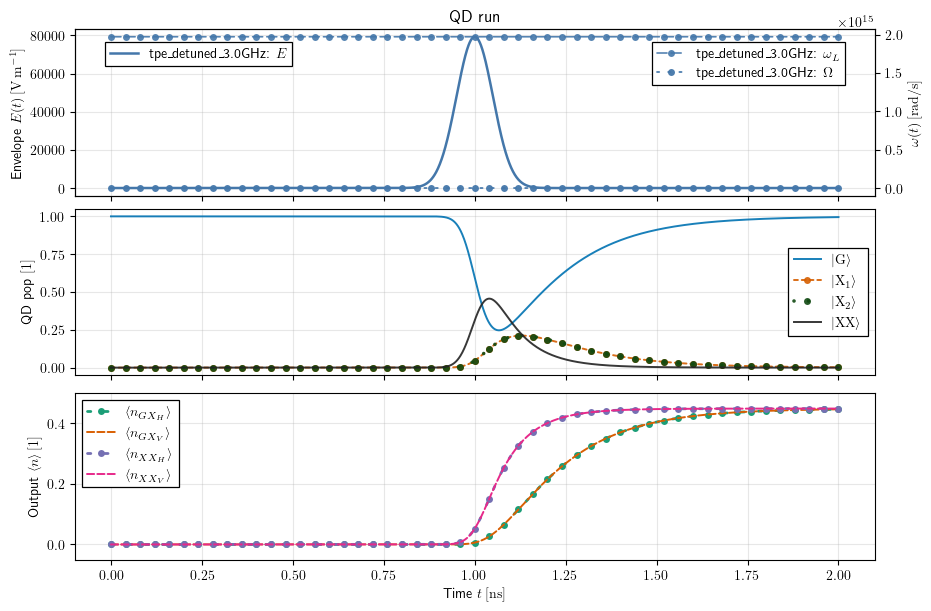

In [21]:

def run_tpe_detuned_constant_ns(
    qd: QuantumDot,
    *,
    detune_2ph_GHz: float = 3.0,   # two-photon detuning
    t_end_ns: float = 2.0,
    n_points: int = 2001,
    t0_ns: float = 1.0,
    sigma_ns: float = 0.05,        # 50 ps
):
    # 1 solver unit = 1 ns
    time_unit_s = float(Q(1.0, "ns").to("s").magnitude)
    units = UnitSystem(time_unit_s=time_unit_s)
    engine = SimulationEngine(audit=False)

    # Time grid in ns
    tlist = np.linspace(0.0, float(t_end_ns), int(n_points))

    # Initial state creation
    bundle = qd.compile_bundle(units=units)
    dims = bundle.modes.dims()
    rho0 = rho0_qd_vacuum(dims=dims, qd_state=QDState.G)

    # Resonant carrier
    omega_G_XX = float(qd.derived.omega_ref_rad_s(TransitionPair.G_XX))
    omega_L_res = 0.5 * omega_G_XX
    delta_L_rad_s = float(Q(detune_2ph_GHz, "GHz").to("rad/s").magnitude)
    omega_L = omega_L_res + delta_L_rad_s

 

    drive = make_gaussian_field_drive_pi(
        qd,
        pair=TransitionPair.G_XX,
        t0=Q(float(t0_ns), "ns"),
        sigma=Q(float(sigma_ns), "ns"),
        preferred_kind="2ph",
        label=f"tpe_detuned_{detune_2ph_GHz:.1f}GHz",
        include_polaron=True,
        omega0_rad_s=omega_L,      # constant, detuned
        chirp_rate_rad_s2=None,   # explicitly no chirp
    )
    time_unit_s = float(Q(1.0, "ns").to("s").magnitude)
    units = UnitSystem(time_unit_s=time_unit_s)
    print(drive.report_plain(time_unit_s=time_unit_s))
    drive1 = ClassicalFieldDriveU(
        envelope=GaussianEnvelopeU(t0=Q(1,"ns"), sigma=Q(50, "ps")),
        amplitude=FieldAmplitude(E0=Q(79247, "V/m")),
        carrier=Carrier(omega0=Q(1.97e15, "rad/s"), delta_omega=constant_detune(Q(2e10, "rad/s"))),#, delta_omega=Q(2e10, "rad/s")),
        pol_state=JonesState.H(),
        label="tpe_detuned_1"
    )
    print(drive1.report_plain(time_unit_s=time_unit_s))

    

    specs = [DriveSpec(payload=drive, drive_id=drive.label)]


    res = engine.run(
        qd,
        tlist=tlist,
        time_unit_s=time_unit_s,
        rho0=rho0,
        drives=specs,
        solve_options=_SOLVE_OPTIONS,
    )

    return res, drive, tlist, units
qd=make_qd()
res, drive, tlist, units = run_tpe_detuned_constant_ns(qd)
plot_run(res, units=units, drives=[drive], qd=qd);

chosen_final: [('G<->XX', '2ph', 1.0, 0.0, 0.0)]


  0%|          | 0/2000 [00:00<?, ?it/s]

QUANTUM DOT METRICS REPORT

STATE SANITY
------------------------------------------------------------------------------
Trace               : 1
Hermiticity error   : 7.85161e-17
Min eigenvalue      : -7.45112e-17

QD POPULATIONS (final state)
------------------------------------------------------------------------------
  G : 0.994564
 X1 : 0.00265572
 X2 : 0.00265572
 XX : 0.000124219

PHOTON NUMBER DECOMPOSITION (GX + XX)
------------------------------------------------------------------------------
p0        : 0.0638319
p1_total  : 0.00443971
p2_exact  : 0.911155

PHOTON NUMBER DECOMPOSITION (GX only)
------------------------------------------------------------------------------
p0        : 0.0682716
p1_total  : 0.912027
p2_exact  : 0.0197013

PHOTON NUMBER DECOMPOSITION (XX only)
------------------------------------------------------------------------------
p0        : 0.0638319
p1_total  : 0.915595
p2_exact  : 0.020573

PHOTON NUMBER EXPECTATION VALUES
----------------------------

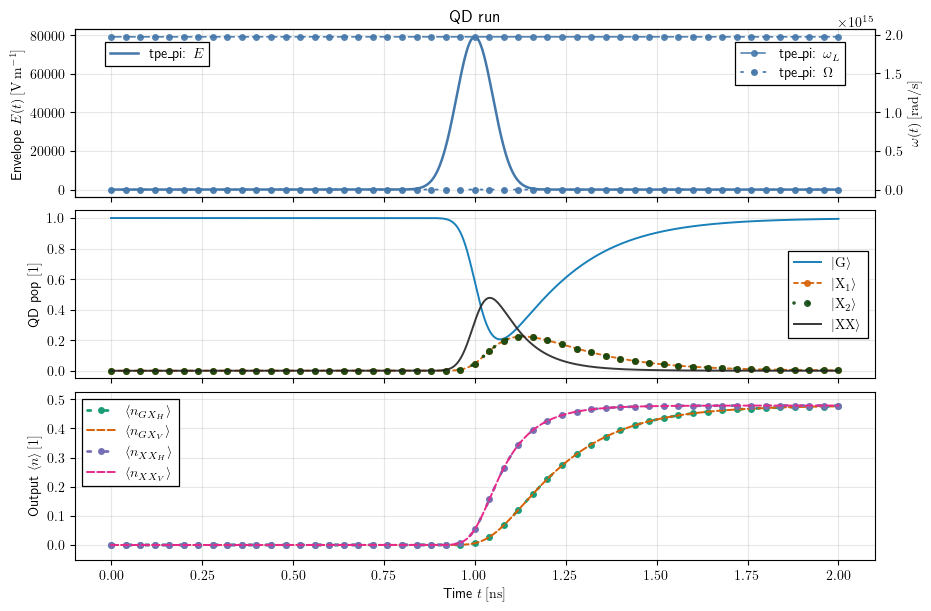

In [22]:
def run_tpe_excitation_overdrive_ns(
    qd: QuantumDot,
    *,
    t_end_ns: float = 2.0,
    n_points: int = 2001,
    t0_ns: float = 1.0,
    sigma_ns: float = 0.05,   # 50 ps
):
    # 1 solver unit = 1 ns
    time_unit_s = float(Q(1.0, "ns").to("s").magnitude)
    units = UnitSystem(time_unit_s=time_unit_s)
    engine = SimulationEngine(audit=False)

    # Time axis in ns (because time_unit_s=1 ns)
    tlist = np.linspace(0.0, float(t_end_ns), int(n_points))

    bundle = qd.compile_bundle(units=units)
    dims = bundle.modes.dims()
    rho0 = rho0_qd_vacuum(dims=dims, qd_state=QDState.G)

    # Two-photon resonance: omega_L = 0.5 * omega_ref(G<->XX)
    omega_G_XX = float(qd.derived.omega_ref_rad_s(TransitionPair.G_XX))
    omega_L = 0.5 * omega_G_XX

    drive = make_gaussian_field_drive_pi(
        qd,
        pair=TransitionPair.G_XX,
        t0=Q(float(t0_ns), "ns"),
        sigma=Q(float(sigma_ns), "ns"),
        preferred_kind="2ph",
        label="tpe_pi",
        include_polaron=True,
        omega0_rad_s=omega_L,
        chirp_rate_rad_s2=None,
    )
    drive = drive.scaled(5.0)

    specs = [DriveSpec(payload=drive, drive_id=drive.label or "tpe")]



    res = engine.run(
        qd,
        tlist=tlist,
        time_unit_s=time_unit_s,
        rho0=rho0,
        drives=specs,
        solve_options=_SOLVE_OPTIONS,
    )

    return res, drive, tlist, units
qd=make_qd()
res, drive, tlist, units = run_tpe_excitation_ns(qd)
plot_run(res, units=units, drives=[drive], qd=qd);
metrics = QDDiagnostics().compute(qd, res, units=units)
print(metrics.to_text())
